In [3]:
"""
Compute Starlink satellites that satisfy user-defined
elevation / azimuth / range constraints and express their
locations in a local ENU Cartesian frame whose origin is the
ground station (x = East, y = North, z = Up).
"""

import numpy as np
import pandas as pd
import requests
from skyfield.api import load, EarthSatellite, wgs84
from skyfield.framelib import itrs  # Earth-fixed ITRF frame
ts = load.timescale()


# ───────────────────────────────────────────────────────────────
# 3) Download Starlink TLEs and append satellites
# ----------------------------------------------------------------
url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle"
HEADERS = {"User-Agent": "sat-tracker/1.0 (+https://github.com/you/repo)"}
tle_lines = requests.get(url, timeout=10).text.strip().splitlines()

sats = []
for i in range(0, len(tle_lines) - 2, 3):  # Process full TLE blocks
    name = tle_lines[i].strip()
    l1 = tle_lines[i+1].strip()
    l2 = tle_lines[i+2].strip()
    if not (l1.startswith("1 ") and l2.startswith("2 ")):
        continue
    try:
        sats.append((name, EarthSatellite(l1, l2, name, ts)))
    except ValueError:
        continue
    
    


In [4]:
# ───────────────────────────────────────────────────────────────
# 0) User-configurable parameters
# ----------------------------------------------------------------
ELEV_MIN_DEG   = 10           # Minimum elevation (deg)
AZ_RANGE_DEG   = (0, 360)     # Azimuth range [start, end)
MAX_SLANT_KM   = 9999         # Maximum slant range (km)

# ───────────────────────────────────────────────────────────────
# 1) Observer definition (Boulder, CO)
# ----------------------------------------------------------------
lat, lon, elev = 40.0822, -105.1092, 1560  # meters
ts = load.timescale()
t = ts.now()
topos = wgs84.latlon(lat, lon, elev)

# Build ECEF → ENU rotation matrix
phi = np.radians(lat)
lam = np.radians(lon)
R_ecef2enu = np.array([
    [-np.sin(lam),              np.cos(lam),               0.0],
    [-np.sin(phi)*np.cos(lam), -np.sin(phi)*np.sin(lam),  np.cos(phi)],
    [ np.cos(phi)*np.cos(lam),  np.cos(phi)*np.sin(lam),  np.sin(phi)]
])

# ───────────────────────────────────────────────────────────────
# 2) Initialize empty list to hold satellite rows
# ----------------------------------------------------------------
rows = []




# ───────────────────────────────────────────────────────────────
# 4) Evaluate satellites
# ----------------------------------------------------------------
for name, sat in sats:
    alt, az, dist = (sat - topos).at(t).altaz()
    slant_km = dist.km

    if alt.degrees < ELEV_MIN_DEG:
        continue
    if not (AZ_RANGE_DEG[0] <= az.degrees < AZ_RANGE_DEG[1]):
        continue
    if slant_km > MAX_SLANT_KM:
        continue

    sat_ecef = sat.at(t).frame_xyz(itrs).m
    obs_ecef = topos.at(t).frame_xyz(itrs).m
    enu = R_ecef2enu @ (sat_ecef - obs_ecef)

    rows.append([
        name,
        round(az.degrees, 2),
        round(alt.degrees, 2),
        round(slant_km, 1),
        *np.round(enu, 1)
    ])

# ───────────────────────────────────────────────────────────────
# 5) Output results
# ----------------------------------------------------------------
columns = ["Name", "Azimuth (°)", "Elevation (°)", "Slant km",
           "x_East (m)", "y_North (m)", "z_Up (m)"]
df = pd.DataFrame(rows, columns=columns)

# Optional: sort by slant distance
df = df.sort_values(by="Slant km", ascending=True).reset_index(drop=True)

print(df.to_string(index=False))


                Name  Azimuth (°)  Elevation (°)  Slant km  x_East (m)  y_North (m)  z_Up (m)
STARLINK-11508 [DTC]       106.28          51.94     447.2    264646.3     -77276.7  352078.5
      STARLINK-31565       312.36          60.87     549.3   -197637.2     180185.2  479839.3
      STARLINK-32802       297.67          58.33     563.2   -261849.2     137294.3  479321.7
       STARLINK-6290        64.54          77.80     572.9    109306.5      52041.1  559963.7
      STARLINK-32320        75.93          53.73     590.2    338708.4      84898.3  475796.1
       STARLINK-6176       287.25          67.83     601.7   -216885.6      67325.9  557219.8
      STARLINK-31809        13.14          51.70     606.3     85423.8     365927.6  475863.1
       STARLINK-4346       295.81          62.73     607.4   -250539.4     121156.1  539879.4
      STARLINK-34269       340.57          50.87     612.0   -128468.4     364246.7  474696.8
       STARLINK-2651       120.47          62.23     613.2  

In [5]:
from datetime import datetime, timedelta
from skyfield.api import utc
import numpy as np
import pandas as pd

# ───────────────────────────────────────────────────────────────
# Observer definition (Boulder, CO)
# ----------------------------------------------------------------
lat, lon, elev = 40.0822, -105.1092, 1560  # meters
topos = wgs84.latlon(lat, lon, elev)

# Build ECEF → ENU rotation matrix
phi = np.radians(lat)
lam = np.radians(lon)
R_ecef2enu = np.array([
    [-np.sin(lam),              np.cos(lam),               0.0],
    [-np.sin(phi)*np.cos(lam), -np.sin(phi)*np.sin(lam),  np.cos(phi)],
    [ np.cos(phi)*np.cos(lam),  np.cos(phi)*np.sin(lam),  np.sin(phi)]
])

# ───────────────────────────────────────────────────────────────
# Sampling every 5 seconds for 15 minutes
# ----------------------------------------------------------------
ELEV_MIN_DEG = 30
AZ_RANGE_DEG = (0, 360)
MAX_SLANT_KM = 9999
DURATION_SEC = 15 * 60         # 15 minutes
INTERVAL_SEC = 3               # 5-second interval

rows = []
start_time = datetime.utcnow().replace(tzinfo=utc)

for i in range(0, DURATION_SEC, INTERVAL_SEC):
    current_dt = start_time + timedelta(seconds=i)
    t = ts.utc(current_dt)

    for name, sat in sats:
        alt, az, dist = (sat - topos).at(t).altaz()
        if alt.degrees < ELEV_MIN_DEG:
            continue
        if not (AZ_RANGE_DEG[0] <= az.degrees < AZ_RANGE_DEG[1]):
            continue
        if dist.km > MAX_SLANT_KM:
            continue

        sat_ecef = sat.at(t).frame_xyz(itrs).m
        obs_ecef = topos.at(t).frame_xyz(itrs).m
        enu = R_ecef2enu @ (sat_ecef - obs_ecef)

        rows.append([
            current_dt.strftime("%Y-%m-%d %H:%M:%S"),
            name,
            round(az.degrees, 2),
            round(alt.degrees, 2),
            round(dist.km, 1),
            *np.round(enu, 1)
        ])

# ───────────────────────────────────────────────────────────────
# Save to CSV
# ----------------------------------------------------------------
columns = ["Time", "Name", "Azimuth (°)", "Elevation (°)", "Slant km",
           "x_East (m)", "y_North (m)", "z_Up (m)"]
df = pd.DataFrame(rows, columns=columns)

df = df.sort_values(by=["Time", "Slant km"]).reset_index(drop=True)
df.to_csv("starlink_visibility_15min_5s_interval.csv", index=False)


/tmp/ipykernel_142101/1676840112.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("tab20")


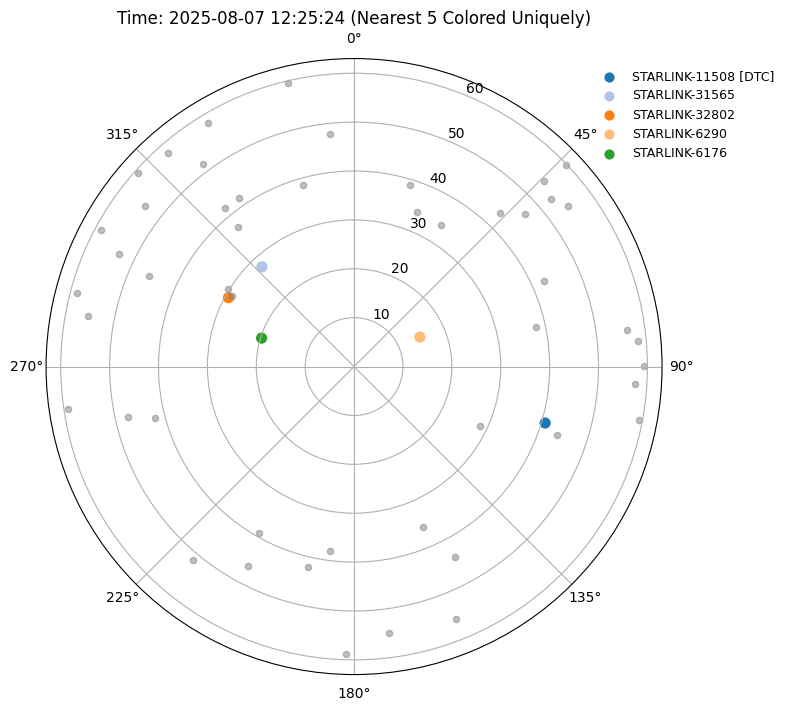

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import itertools
from matplotlib import cm

# Load CSV
df = pd.read_csv("starlink_visibility_15min_5s_interval.csv")
grouped = df.groupby("Time")
time_points = list(grouped.groups.keys())


# Color generator from tab20 (20 unique colors, looped if exhausted)
colormap = cm.get_cmap("tab20")
color_palette = itertools.cycle([colormap(i) for i in range(20)])

global_color_map = {}  # name → color

# Setup figure
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90 - ELEV_MIN_DEG + 3)

scat_top5 = ax.scatter([], [], s=50)
scat_others = ax.scatter([], [], s=20, c='gray', alpha=0.5)
title_text = ax.set_title("", fontsize=12)

# Initialize legend handles
legend_handles = []

def update(frame):
    global legend_handles
    time = time_points[frame]
    data = grouped.get_group(time).sort_values(by="Slant km")

    top5 = data.head(5)
    others = data.iloc[5:]

    # Assign new color if satellite never seen before
    for name in top5["Name"]:
        if name not in global_color_map:
            global_color_map[name] = next(color_palette)

    # Extract coordinates
    theta_top5 = np.radians(top5["Azimuth (°)"])
    radius_top5 = 90 - top5["Elevation (°)"]
    colors_top5 = [global_color_map[name] for name in top5["Name"]]

    theta_others = np.radians(others["Azimuth (°)"])
    radius_others = 90 - others["Elevation (°)"]

    # Update scatter plot
    scat_top5.set_offsets(np.c_[theta_top5, radius_top5])
    scat_top5.set_color(colors_top5)

    scat_others.set_offsets(np.c_[theta_others, radius_others])
    title_text.set_text(f"Time: {time} (Nearest 5 Colored Uniquely)")

    # Update legend
    for h in legend_handles:
        h.remove()
    legend_handles = []

    for name in top5["Name"]:
        color = global_color_map[name]
        h = ax.scatter([], [], c=[color], label=name, s=40)
        legend_handles.append(h)

    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=9, frameon=False)

    return scat_top5, scat_others, title_text, *legend_handles

ani = FuncAnimation(fig, update, frames=len(time_points), interval=200, blit=False)
ani.save("starlink_unique_color.gif", dpi=120, writer="pillow")

# Or save as mp4
# ani.save("starlink_unique_color.mp4", dpi=120, writer="ffmpeg")
